In [1]:
import sys
import os
SCRIPT_DIR = os.path.dirname(os.path.abspath("."))
sys.path.append(SCRIPT_DIR)
import helper
from utils import data_utils
import matplotlib.pyplot as plt
from utils import training_utils
from utils import data_utils
import torch
from model import models
import json
import os
from model import lightning_models
import math
from torchvision import datasets
import analysis_utils
import numpy as np
import random
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

/home/richard/miniconda3/envs/dl_env/lib/python3.12/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.4 (you have 1.4.23). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [55]:
n_views = 1
batch_size = 4
model_dir = "../traning/lr_3.0"

In [56]:
config = helper.Config(model_dir,default_config_file="../default_configs/default_config_imagenet.ini")
if "CIFAR" in config.DATA["dataset"] or "MNIST" in config.DATA["dataset"]:
    prune_backbone = True
else:
    prune_backbone = False
ssl_model = lightning_models.CLAP(backbone_name = config.SSL["backbone"],
                                  prune = prune_backbone,
                                  use_projection_head=config.SSL["use_projection_head"],
                                  proj_dim = config.SSL["proj_dim"],
                                  proj_out_dim = config.SSL["proj_out_dim"],
                                  loss_name= config.SSL["loss_function"],
                                  optim_name = config.SSL["optimizer"],
                                  lr = 1.0,
                                  scheduler_name = config.SSL["lr_scheduler"],
                                  momentum = config.SSL["momentum"],
                                  weight_decay = config.SSL["weight_decay"],
                                  eta = config.SSL["lars_eta"],
                                  warmup_epochs = config.SSL["warmup_epochs"],
                                  n_epochs = config.SSL["n_epochs"],
                                  n_views = config.DATA["n_views"],
                                  batch_size = config.SSL["batch_size"],
                                  lw0 = config.SSL["lw0"],
                                  lw1 = config.SSL["lw1"],
                                  lw2 = config.SSL["lw2"],
                                  rs = config.SSL["rs"],
                                  pot_pow = config.SSL["pot_pow"])

Loading default settings...
[INFO]does not exist in the config file
[DATA]does not exist in the config file
[SSL]does not exist in the config file
[LC]does not exist in the config file
[SemiSL]does not exist in the config file
[TL]does not exist in the config file
[SemiSL]does not exist in the config file
[TL]does not exist in the config file
[INFO]
num_nodes = 2
gpus_per_node = 4
cpus_per_gpu = 12
prefetch_factor = 2
precision = 16-mixed
fix_random_seed = True
strategy = ddp
if_profile = False

[DATA]
dataset = IMAGENET1K-30percent
n_views = 8
augmentation_package = albumentations
augmentations = ['RandomResizedCrop', 'GaussianBlur', 'RandomGrayscale', 'ColorJitter', 'RandomHorizontalFlip', 'RandomSolarize']
crop_size = 224
crop_min_scale = 0.08
crop_max_scale = 1.0
hflip_prob = 0.5
blur_kernel_size = 23
blur_prob = 0.5
grayscale_prob = 0.2
jitter_brightness = 0.8
jitter_contrast = 0.8
jitter_saturation = 0.8
jitter_hue = 0.2
jitter_prob = 0.8
solarize_prob = 0.0
imagenet_train_dir = 

In [57]:
val_dir = "../datasets/imagenet1k/val/val.lmdb"
aug_ops = ["ToTensor","Normalize","RandomResizedCrop"]
num_classes= 5
mean= [0.485, 0.456, 0.406]
std= [0.229, 0.224, 0.225]
if val_dir.endswith("lmdb"):
    img_type = "PIL" 
    val_dataset = data_utils.ImageFolderLMDB(val_dir,img_type=img_type)
else:
    val_dataset = datasets.ImageFolder(root=val_dir)
classes = random.sample(list(range(1000)),num_classes)
sub_indices = [i for i in range(len(val_dataset)) if val_dataset[i][1] in classes]
val_dataset = torch.utils.data.Subset(val_dataset, sub_indices)
config.DATA["mean4norm"] = mean
config.DATA["std4norm"] = std     
transform = data_utils.get_transform(aug_ops,aug_params=config.DATA,aug_pkg="torchvision")
val_dataset = data_utils.WrappedDataset(val_dataset,transform,n_views = n_views,aug_pkg="torchvision")
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size = batch_size,shuffle=True,drop_last=True,
                                            num_workers=4,pin_memory=True,persistent_workers=True)

In [64]:
device = torch.device("cuda:0")  # Use GPU 0
trained_filename = os.path.join(model_dir,"ssl",'best_val.ckpt')
if os.path.isfile(trained_filename):
    print(f'Found pretrained model at {trained_filename}, loading...')
    ssl_model = lightning_models.CLAP.load_from_checkpoint(trained_filename)
ssl_model.backbone.remove_projection_head()
backbone = ssl_model.backbone.to(device)

Found pretrained model at ../traning/lr_3.0/ssl/best_val.ckpt, loading...
max_mem_size is dummy for RepulsiveEllipsoidPackingLossUnitNorm
lw2 is dummy for RepulsiveEllipsoidPackingLossUnitNorm


In [65]:
def get_representations(backbone,test_dataset,count=2400):
    test_loader = torch.utils.data.DataLoader(test_dataset,batch_size = batch_size,shuffle=True,drop_last=True,
                                              num_workers = 4,pin_memory=True)
    rep_vecs = []
    all_labels =[]
    i = 0
    for i,data in enumerate(test_loader):
        imgs,labels = data
        if i > count - 1:
            break
        all_labels.append(labels[0].detach().cpu())
        imgs = torch.cat(imgs,dim=0).to(device)
        with torch.no_grad():
            preds = backbone(imgs)
            preds = torch.reshape(preds,(batch_size,preds.shape[-1]))
            centers = torch.mean(preds,dim=0)
            preds -= centers
            rep_vecs.append(preds)
            
    rep_vecs = torch.cat(rep_vecs,dim=0).detach().cpu().numpy()
    all_labels = torch.cat(all_labels,dim=-1).detach().cpu().numpy()
    return rep_vecs,all_labels

In [66]:
x,y = get_representations(backbone,val_dataset,count=3000)

In [67]:
t_sne = TSNE(
    n_components=2,
    perplexity=30,
    max_iter=600,
    random_state=0,
)
X = t_sne.fit_transform(x)

In [72]:
def plot_embedding(x,y,classes, title):
    _, ax = plt.subplots()
    #X = MinMaxScaler().fit_transform(x)
    color = 0
    for c in classes:
        pos = np.where(y==c)
        print(X[pos].shape)
        ax.scatter(
            X[pos][:,0],X[pos][:,1],
            marker=".",
            s=60,
            color=plt.cm.tab10(color),
            alpha=1.0,
            zorder=2,label = str(c)
        )
        color += 1
    ax.set_title(title)
    ax.axis("off")
    ax.legend()

(50, 2)
(50, 2)
(50, 2)
(50, 2)
(48, 2)


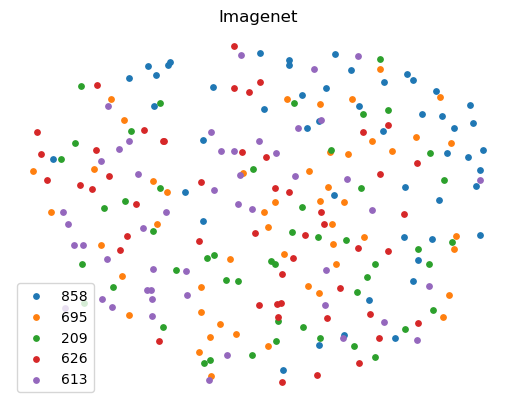

In [73]:
plot_embedding(X,y,classes,"Imagenet")

In [74]:
model_dir = "../traning/lr_1.0"
config = helper.Config(model_dir,default_config_file="../default_configs/default_config_imagenet.ini")
if "CIFAR" in config.DATA["dataset"] or "MNIST" in config.DATA["dataset"]:
    prune_backbone = True
else:
    prune_backbone = False
ssl_model = lightning_models.CLAP(backbone_name = config.SSL["backbone"],
                                  prune = prune_backbone,
                                  use_projection_head=config.SSL["use_projection_head"],
                                  proj_dim = config.SSL["proj_dim"],
                                  proj_out_dim = config.SSL["proj_out_dim"],
                                  loss_name= config.SSL["loss_function"],
                                  optim_name = config.SSL["optimizer"],
                                  lr = 1.0,
                                  scheduler_name = config.SSL["lr_scheduler"],
                                  momentum = config.SSL["momentum"],
                                  weight_decay = config.SSL["weight_decay"],
                                  eta = config.SSL["lars_eta"],
                                  warmup_epochs = config.SSL["warmup_epochs"],
                                  n_epochs = config.SSL["n_epochs"],
                                  n_views = config.DATA["n_views"],
                                  batch_size = config.SSL["batch_size"],
                                  lw0 = config.SSL["lw0"],
                                  lw1 = config.SSL["lw1"],
                                  lw2 = config.SSL["lw2"],
                                  rs = config.SSL["rs"],
                                  pot_pow = config.SSL["pot_pow"])
device = torch.device("cuda:0")  # Use GPU 0
trained_filename = os.path.join(model_dir,"ssl",'best_val.ckpt')
if os.path.isfile(trained_filename):
    print(f'Found pretrained model at {trained_filename}, loading...')
    ssl_model = lightning_models.CLAP.load_from_checkpoint(trained_filename)
ssl_model.backbone.remove_projection_head()
backbone = ssl_model.backbone.to(device)

Loading default settings...
[INFO]does not exist in the config file
[DATA]does not exist in the config file
[SSL]does not exist in the config file
[LC]does not exist in the config file
[SemiSL]does not exist in the config file
[TL]does not exist in the config file
[SemiSL]does not exist in the config file
[TL]does not exist in the config file
[INFO]
num_nodes = 2
gpus_per_node = 4
cpus_per_gpu = 12
prefetch_factor = 2
precision = 16-mixed
fix_random_seed = True
strategy = ddp
if_profile = False

[DATA]
dataset = IMAGENET1K-30percent
n_views = 8
augmentation_package = albumentations
augmentations = ['RandomResizedCrop', 'GaussianBlur', 'RandomGrayscale', 'ColorJitter', 'RandomHorizontalFlip', 'RandomSolarize']
crop_size = 224
crop_min_scale = 0.08
crop_max_scale = 1.0
hflip_prob = 0.5
blur_kernel_size = 23
blur_prob = 0.5
grayscale_prob = 0.2
jitter_brightness = 0.8
jitter_contrast = 0.8
jitter_saturation = 0.8
jitter_hue = 0.2
jitter_prob = 0.8
solarize_prob = 0.0
imagenet_train_dir = 

In [77]:
x,y = get_representations(backbone,val_dataset,count=3000)
t_sne = TSNE(
    n_components=2,
    perplexity=30,
    max_iter=800,
    random_state=0,
)
X = t_sne.fit_transform(x)

(50, 2)
(50, 2)
(49, 2)
(49, 2)
(50, 2)


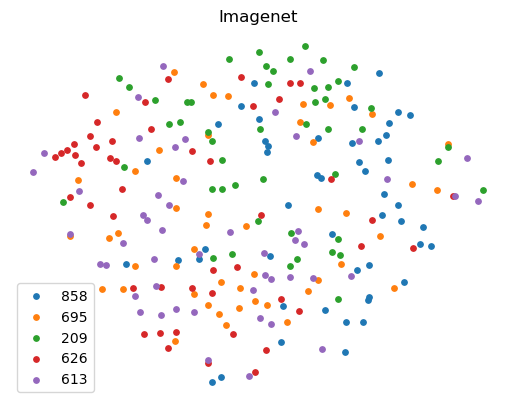

In [78]:
plot_embedding(X,y,classes,"Imagenet")